## Initialize values

In [1]:
import os,sys
sys.path.append('..')

from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

sns.set_theme(palette="colorblind", style="ticks")
plt.rcParams.update({
            "font.family": "serif",
            "font.serif" : "Times New Roman",
            "font.size": 10,
            "axes.titlesize": "medium",
            "axes.labelsize": "medium",
            "xtick.labelsize": "medium",
            "ytick.labelsize": "medium",
            "legend.fontsize": "medium",
            "legend.title_fontsize": "medium",
            "text.usetex": True,
            "text.latex.preamble": r"\usepackage{lmodern,newtxmath} \usepackage[utf8]{inputenc} \usepackage[T1]{fontenc}",
            'axes.linewidth':1,
            'xtick.major.width':1,
            'ytick.major.width':1,
            'ytick.minor.visible':False,
            # 'savefig.pad_inches' : 0.02,
        },)

model_params = {\
    "thickness" : {"thick": 0.0013, "thin": 0.0003},
    "E" : {"70_S":2508*3,"70_H":16082*3,"80_S":9344*3,"80_H":17507*3},
    "E_max" : {"70_S":(2508+21)*3,"70_H":(16082+167)*3,"80_S":(9344+50)*3,"80_H":(17507+200)*3},
    "E_min" : {"70_S":(2508-21)*3,"70_H":(16082-167)*3,"80_S":(9344-50)*3,"80_H":(17507-200)*3},
    "upsilon" : (0.059+0.016)/2, # from Park et al, Ups_s = Ups_SV + Ups_SL / 2
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
}

source_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\raw_data")

eval_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\eval\public")
if not eval_dir.exists(): eval_dir.mkdir()

order = ["80_S_thin", "80_S_thick", "80_H_thin", "80_H_thick"]    

plot_out_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots\public")


## Raw Data Processing

In [3]:
import numpy as np
from pathlib import Path
import pickle
import traceback
from ridge_eval.ridge_extractor import extract_ridge_from_image

def extract_ridge(file):
    radius, ridge, image, circ_params, _, r2, pixelscale,stdev,sterr = \
            extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.005, gamma_correction=3, max_rel_diff_to_circle=.005,prune_profiles=True)

    return circ_params,radius,r2,image,pixelscale,ridge,stdev,sterr

sources = source_dir.rglob("*.pkl.gz")
for file in sources:
    print(f"{file.stem}", end="")
    target_path = file.relative_to(source_dir)
    target_file = (eval_dir / target_path).with_suffix(".pkl")
    target_file.parent.mkdir(parents=True, exist_ok=True)
    if target_file.exists():
        print(f" - File exists, skipping")
        continue

    try:
        result = extract_ridge(file)
    except Exception as e:
        print(f" - Error: {e}, {traceback.format_exc()}")
        continue

    print(f" - Circle: {result[0]} Radius: {result[1]:.6f} R2: {result[2]:.4f}")
    
    iron_content, shear_mod, drop_vol, thickness,_,magntype, *_ = Path(file).stem.split("_")
    pickle.dump(result + (iron_content,shear_mod,drop_vol,thickness,magntype), open(target_file, "wb"))



80_H_1_thick_magn_10mT_f.pkl

c:\Users\krr38985\Documents\Python\ridge_evaluation\.venv\Lib\site-packages\skimage\measure\fit.py:308: UserWarning: Input does not contain enough significant data points.
  warn("Input does not contain enough significant data points.")


 - Error: need at least one array to concatenate, Traceback (most recent call last):
  File "C:\Users\krr38985\AppData\Local\Temp\ipykernel_20036\879902586.py", line 24, in <module>
    result = extract_ridge(file)
             ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krr38985\AppData\Local\Temp\ipykernel_20036\879902586.py", line 9, in extract_ridge
    extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.005, gamma_correction=3, max_rel_diff_to_circle=.005,prune_profiles=True)
  File "c:\Users\krr38985\Documents\Python\ridge_evaluation\notebooks\..\ridge_eval\ridge_extractor.py", line 359, in extract_ridge_from_image
    circle_fit_radius,radial_profile, stdev, sterr = _robust_radial_profile(image, (yc,xc,r), pixelscale, max_rel_diff_to_circle=max_rel_diff_to_circle, prune_profiles=prune_profiles)
                                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

0.9563288925080233
(6.340230200256826e-07, 6.32887341795143e-07)


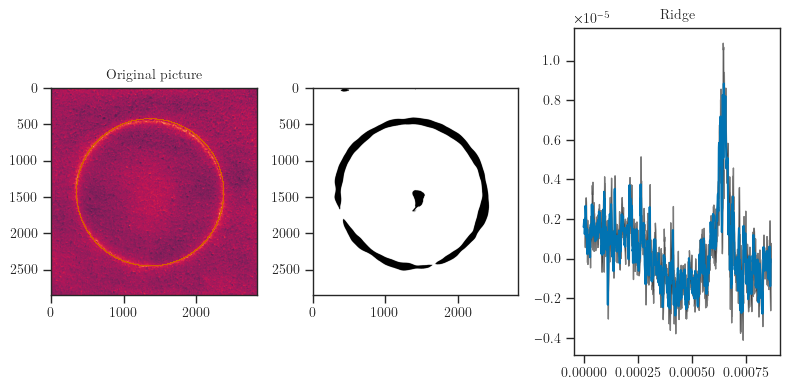

In [6]:
from ridge_eval.ridge_extractor import *
import tifffile
from fractions import Fraction
from skimage.draw import circle_perimeter
from skimage.filters import gaussian, median
from skimage.morphology import disk, rectangle
file = Path(r"D:\Publications\Paper4-Wetting-ridge\raw_data\compare_magn\80_S_1_thin_mag_220mT_f.ome.tif")
with tifffile.TiffFile(file) as tif:
    image = tif.asarray()
    ome_metadata = tif.ome_metadata
    metadata = tif.pages[0].tags
    # The TIFF types of the XResolution and YResolution tags are RATIONAL (5)
    # which is defined in the TIFF specification as two longs, the first of which is the numerator and the second the denominator.
    xres = Fraction(*metadata["XResolution"].value)*1e6
    yres = Fraction(*metadata["YResolution"].value)*1e6
    pixelscale = (float(1/xres), float(1/yres))
try:

    # filter_image = median(image, disk(11))
    # high_mask = image > 0.6*filter_image.max()
    # fill_val = np.median(image)
    # image[high_mask] =  fill_val
    # tifffile.imwrite(str(file.with_stem(file.stem + "_filt")), image, 
    #     compression='zstd', compressionargs={"level":9}, tile=(256,256),
    #     # metadata=metadata, #ijmetadata=metadata,
    #     resolution=(xres/1e6, yres/1e6))
    yc,xc,r, r2, rim_binarized = find_features(image, (0.7, False, 10, 0.005, 3))
    print(r2)
    print(pixelscale)

    # ridge = extract_ridge_from_image(img, pixelscale, yc, xc)

    radius, ridge, image, circ_params, _, r2, pixelscale,stdev,sterr = \
        extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.005, gamma_correction=3, max_rel_diff_to_circle=0.005,prune_profiles=True)
    # yc,xc,r = circ_params
    # print(f"{file.stem} Center: ({yc},{xc}) Radius: {r} R2: {r2}")

    cy, cx = circle_perimeter(yc,xc,r)
    fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(8, 4))

    ax1.set_title('Original picture')
    ax1.imshow(image)
    ax1.plot(cx,cy, "r,")
    cy,cx = circle_perimeter(circ_params[0],circ_params[1],circ_params[2])
    # ax1.plot(cx,cy, "g,")
    # ax2.set_title('Rim')
    ax2.imshow(rim_binarized, cmap="Greys")
    
    ax3.set_title('Ridge')
    ax3.fill_between(ridge[0], ridge[1]-sterr, ridge[1]+sterr, color="black", alpha=0.5)
    ax3.plot(ridge[0], ridge[1])
    plt.tight_layout()
    plt.show()
    # df = pd.DataFrame({"x":ridge[0],"y":ridge[1]})
    # df.to_csv(file.with_suffix(".rdg"), sep=";")
except Exception as e:
    print(e)
    print(file)

## Data Ingestion & Postprocessing

In [4]:
from ridge_eval.ridge_models import style_exact
import numpy as np
from scipy.signal import savgol_filter
df_list = list()

for file in eval_dir.rglob("*.pkl"):
    if "ignore" in str(file):
        continue
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,ridge,stdev,sterr,iron_content,matrix,drop_vol,thickness,magntype = pickle.load(f)

    if file.stem in ["80_H_1_thin_magn_10mT_f.ome", "80_H_1_thin_magn_30mT_f.ome","80_H_1_thick_magn_10mT_f.ome", "80_H_1_thick_magn_30mT_f.ome"]:
        df = pd.DataFrame({ "x":[np.nan], "norm_x":[np.nan], "y":[np.nan], "y_err": [np.nan], 
                        "y_smooth":[np.nan], "y_err_smooth":[np.nan], "fit_y_th":[np.nan],
                        "iron_content":iron_content, "matrix":matrix, "drop_vol":drop_vol, "thickness":thickness, "magntype":magntype, "R2":r2, "radius":radius})
    else:
        x,y = ridge
        y = y*1e6

        
        fit_y_th = 1e6*style_exact(x, model_params["gamma"], radius, model_params["gamma"], model_params["E"][f"{iron_content}_{matrix}"], model_params["thickness"][f"{thickness}"])
        # 0 degree savgol filter equals moving average, yes this is the easiest way to do this
        x= x*1e6
        radius = radius*1e6
        stdev = stdev*1e6
        sterr = sterr*1e6
        norm_x = x / radius

        y = savgol_filter(y, 25, 0)
        stdev_smooth = savgol_filter(stdev, 25, 0)
        sterr_smooth = savgol_filter(sterr, 25, 0)

        df = pd.DataFrame({ "x":[x], "norm_x":[norm_x], "y":[y], "y_err": [sterr], 
                            "y_smooth":[y], "y_err_smooth":[sterr_smooth], "fit_y_th":[fit_y_th], "peak_height":max(y), "peak_height_err":max(sterr), "fit_max":max(fit_y_th),
                            "iron_content":iron_content, "matrix":matrix, "drop_vol":drop_vol, "thickness":thickness, "magntype":magntype, "R2":r2, "radius":radius})
    
    df_list.append(df)
    print(f"{file.stem} - R2: {r2:.3f} - r {radius}")

master_data = pd.concat(df_list, ignore_index=True)
master_data["id"] = master_data["iron_content"] + "_" + master_data["matrix"] + "_" + master_data["thickness"]
master_data["magntype_disp"] = master_data["magntype"].replace({"10mT":"10", "30mT":"$\\uparrow$30", "50mT":"$\\uparrow$50", "quer":"$\\rightarrow$120",
                                                                "120mT":"$\\uparrow$120","220mT":"$\\uparrow$220","270mT":"$\\uparrow$270","380mT":"$\\uparrow$380"})
master_data["magnfield"] = master_data["magntype"].apply(lambda x: int(x.replace("quer","121 mT").replace("mT","").strip())).astype(int)
master_data["thickness_mm"] = master_data["thickness"].replace({"thick":"1.3","thin":"0.3"}).astype(float)
master_data["shear_mod"] = master_data["matrix"].replace({"H":"17.5 kPa","S":"9.3 kPa"})

only120_data_idx = master_data["magntype"].isin(["quer","120mT"])
compare_quer_data = master_data[master_data["magntype"].isin(["quer","120mT"])]
master_data = master_data[master_data["magntype"] != "quer"]

data_120mT = master_data.copy().groupby("magntype").get_group("120mT")
data_120mT = data_120mT.sort_values("id", key=lambda x: x.map(order.index))

80_H_1_thick_magn_120mT_f.pkl - R2: 0.997 - r 553.5020751953125
80_H_1_thick_magn_30mT_f.pkl - R2: 0.888 - r 631.4869384765625
80_H_1_thin_magn_120mT_f.pkl - R2: 0.953 - r 573.7908325195312
80_H_1_thin_mag_220mT_f.pkl - R2: 0.946 - r 737.3687744140625
80_S_1_thick_magn_10mT_f.pkl - R2: 0.878 - r 748.7811889648438
80_S_1_thick_magn_120mT_f.pkl - R2: 0.998 - r 651.775634765625
80_S_1_thick_magn_30mT_f.pkl - R2: 0.995 - r 617.5383911132812
80_S_1_thick_mag_220mT_f.pkl - R2: 0.999 - r 610.5641479492188
80_S_1_thin_magn_10mT_f.pkl - R2: 0.930 - r 610.5641479492188
80_S_1_thin_magn_120mT_f.pkl - R2: 0.998 - r 583.3012084960938
80_S_1_thin_magn_270mT_f.pkl - R2: 0.987 - r 634.6570434570312
80_S_1_thin_magn_50mT_f.pkl - R2: 0.998 - r 720.8841552734375
80_S_1_thin_mag_220mT_f.pkl - R2: 0.998 - r 647.9714965820312


## 2D Experimental plots

### 2D ridge

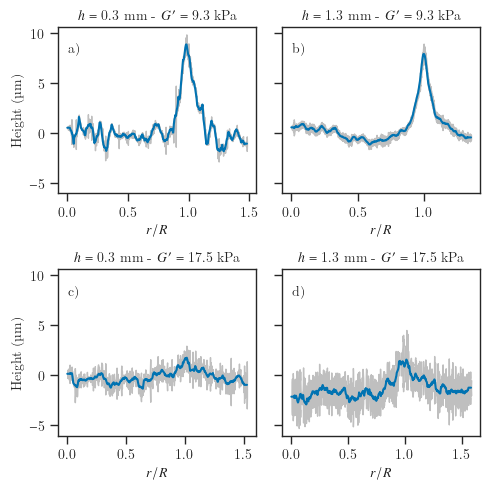

In [5]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=False)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.3$ mm - $G'=9.3$ kPa", "80_S_thick":"$h=1.3$ mm - $G'=9.3$ kPa", "80_H_thin":"$h=0.3$ mm - $G'=17.5$ kPa", "80_H_thick":"$h=1.3$ mm - $G'=17.5$ kPa"}

grp = data_120mT.groupby("id")
for i, key in enumerate(order):
    ax = axes[i//2, i%2]
    df = grp.get_group(key)
    norm_x = df["norm_x"].iloc[0]
    y = df["y"].iloc[0]
    y_err = df["y_err"].iloc[0]
    ax.fill_between(norm_x, y-y_err, y+y_err, color=(0.75,0.75,0.75,1))
    sns.lineplot(x=norm_x, y=y, ax=ax)
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height (µm)")
    # ax.set_xlim(norm_x[y.argmax()-20],norm_x[y.argmax()+20])
    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
plt.tight_layout()
fig.savefig(plot_out_dir / "ridge_fit.pdf", bbox_inches="tight")

### 2D ridge comparison to model calculated with measured values

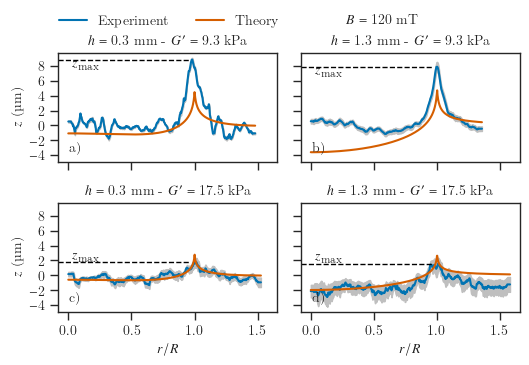

In [7]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.axes import Axes

fig,axes = plt.subplots(2,2, figsize=(5.4,3.5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.3$ mm - $G'=9.3$ kPa", "80_S_thick":"$h=1.3$ mm - $G'=9.3$ kPa", "80_H_thin":"$h=0.3$ mm - $G'=17.5$ kPa", "80_H_thick":"$h=1.3$ mm - $G'=17.5$ kPa"}

plot_data = data_120mT.copy()[["norm_x","y_smooth","y_err_smooth","fit_y_th","id","thickness_mm","shear_mod","magnfield","radius"]]
grp = plot_data.groupby("id")
for i, key in enumerate(order):
    ax: Axes = axes[i//2, i%2]
    df = grp.get_group(key)
    norm_x = df["norm_x"].iloc[0]
    y = np.asarray(df["y_smooth"].iloc[0])
    y_err = np.asarray(df["y_err_smooth"].iloc[0])
    fit_y_th = df["fit_y_th"].iloc[0]
    ax.fill_between(norm_x, y-y_err, y+y_err, color=(0.75,0.75,0.75,1))
    sns.lineplot(x=norm_x, y=y, ax=ax, label="Experiment")
    colorpalette = sns.color_palette()
    sns.lineplot(x=norm_x,y=fit_y_th, ax=ax, color=colorpalette[3], label=f"Theory")

    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("$z$ (µm)")
    ax.text(0.05, 0.1, subplot_labels[i], transform=ax.transAxes)
    ax.get_legend().remove()

    # if i == 0:
    ax.axhline(max(y), 0, .6, color="black", linestyle="--", linewidth=1)
    if i//2 == 0:
        ax.annotate("$z_\\text{max}$", xy=(.12,max(y)-.6), ha="center", xycoords=("axes fraction","data"), va="center")
    else:
        ax.annotate("$z_\\text{max}$", xy=(.12,max(y)+.9), ha="center", xycoords=("axes fraction","data"), va="center")
    # ax.annotate(f"R={df["radius"].iloc[0]:.2f} µm", xy=(0.8,0.8), xycoords="axes fraction", ha="center", va="center")

handles, labels = axes.flatten()[-1].get_legend_handles_labels()
# handles.append(mpatches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0))

axes.flatten()[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
# plt.sca(axes.flatten()[-1])
plt.tight_layout()
def make_legend_arrow(**kwargs): 
    height = kwargs.get("height", 0.5)
    width = kwargs.get("width", 0.5)
    return mpatches.FancyArrow(20,-5,0,height+6, color="black", clip_on=False, head_width=height*0.5)
handles.append(mpatches.Patch(edgecolor="w", facecolor="w"))#mpatches.FancyArrow(0,0,0,0, width = 0, color="black", antialiased=True))
labels.append("$B=120$ mT")
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.45, 1.05), ncol=3, frameon=False,handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),
                    })

# plt.annotate("$\\longrightarrow$", xy=(0.7,0.989), ha="left", rotation=90, xycoords="figure fraction", va="center")
# plt.annotate("$\\vec{B}=120$ mT ", xy=(0.73,0.989), ha="left", xycoords="figure fraction", va ="center")
# plt.tight_layout()

plot_data.rename(columns={"norm_x":"Normalized Radius","y_smooth":"Ridge Height (µm)","y_err_smooth":"Error (µm)","fit_y_th":"Fit (µm)","magnfield":"Magnetic Field (mT)", "shear_mod":"Shear Modulus (kPa)", "thickness_mm":"Thickness (mm)"}, inplace=True)
plot_data.to_json(plot_out_dir / "figure3_ridge_profiles.json", orient="records")
fig.savefig(plot_out_dir / "figure3_ridge_profiles.pdf", bbox_inches="tight")
# fig.savefig(plot_out_dir / "ridge_fit_sc_real.png", bbox_inches="tight")

### 2D ridge compare magn field

In [ ]:
def plot_nested_data(*args,**kwargs):
    color = kwargs.pop("color")
    data = kwargs.pop("data")
    x = np.asarray(data[args[0]].values[0])
    y = np.asarray(data[args[1]].values[0])
    y_err = np.asarray(data["y_err_smooth"].values[0])
    if np.isnan(np.sum(x)) or np.isnan(np.sum(y)):
        plt.annotate("No ridge", (0.5,0.5), xycoords="axes fraction", ha='center', va='center', fontsize=12)
        return
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.5, color=color)
    plt.plot(x,y, color=color, **kwargs)
    max_idx = (np.abs(x - 1)).argmin() # closest val to radius
    max_y = y[max_idx]
    if "label" in kwargs:
        if 0.3 == kwargs["label"]:
            plt.annotate(f"{max_y:0.2f}", (x[max_idx], max_y), textcoords="data", xytext=(0.7,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        else:
            plt.annotate(f"{max_y:0.2f}", (x[max_idx], max_y), textcoords="data", xytext=(1.3,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
    plt.legend()


plot_data = master_data.copy()[["norm_x","y_smooth","y_err_smooth", "magnfield","shear_mod","thickness_mm"]]

# grid = sns.FacetGrid(data=plot_data, col="magnfield", row="shear_mod", hue="thickness_mm", sharex=True, sharey=True, aspect=1, height=3, legend_out=True, 
#                      row_order=["9.3 kPa","17.5 kPa"])
grid = sns.FacetGrid(data=plot_data[plot_data["shear_mod"] == "9.3 kPa"], col="magnfield", hue="thickness_mm", sharex=True, sharey=True, aspect=1, height=3, legend_out=True, 
                     col_wrap=2)

grid.set_titles(template="$B = {col_name}$ mT")
grid.map_dataframe(plot_nested_data, "norm_x", "y_smooth")
# for info,ax in grid.axes_dict.items():
#     plt.sca(ax)
#     plt.annotate(info[0], (-0.8, .5), xycoords="axes fraction", ha='center', va='center', fontsize=12, rotation=90)


# grid.figure.tight_layout()
grid.add_legend(title="$G' = 9.3$ kPa\nThickness (mm)")
grid.set_xlabels("$r/R$")
grid.set_ylabels("$z$ (µm)")
grid.savefig(plot_out_dir / "figureA8_compare_profiles_soft.pdf")
ylim = grid.axes[0].get_ylim()
plt.show()

grid = sns.FacetGrid(data=plot_data[plot_data["shear_mod"] == "17.5 kPa"], col="magnfield", hue="thickness_mm", sharex=True, sharey=True, aspect=1, height=3, legend_out=True, 
                     col_wrap=2, ylim=ylim)

grid.set_titles(template="$B = {col_name}$ mT")
grid.map_dataframe(plot_nested_data, "norm_x", "y_smooth")
# for info,ax in grid.axes_dict.items():
#     if not info: continue
#     plt.sca(ax)
#     plt.annotate(info[0], (-0.8, .5), xycoords="axes fraction", ha='center', va='center', fontsize=12, rotation=90)

# plt.tight_layout()
# grid.figure.tight_layout()

grid.add_legend(title="$G' = 17.5$ kPa\nThickness (mm)" )
grid.set_xlabels("$r/R$")
grid.set_ylabels("$z$ (µm)")
grid.savefig(plot_out_dir / "figureA9_compare_profiles_hard.pdf")



plot_data.rename(columns={"norm_x":"Normalized Radius","y_smooth":"Ridge Height (µm)","y_err_smooth":"Error (µm)","magnfield":"Magnetic Field (mT)", "shear_mod":"Shear Modulus (kPa)", "thickness":"Thickness (mm)"}, inplace=True)
plot_data.to_json(plot_out_dir / "figureA8_9_compare_profiles.json", orient="records")

### Peaks Comparison

In [ ]:
# def catplot_error(err, hue=None, col=None, row=None, data:pd.DataFrame =None, **kwargs) -> sns.FacetGrid:
#     if err is None: raise ValueError("err not given")

#     bar_lbl_fmt = kwargs.pop('bar_lbl_fmt',"%.0f")
#     facet: sns.FacetGrid = sns.catplot(data=data, col=col, row=row, hue=hue, **kwargs)
#     ax_arr = facet.axes
#     _error_df = data.copy(True)

#     _error_df.sort_values(hue,inplace=True)
#     _error_grps = _error_df.groupby(col)

#     for ax, grp  in zip(ax_arr.ravel(order='F'), _error_grps.groups):
#         # error bar
#         x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
#         y_coords = [p.get_height() for p in ax.patches]

#         err_val = _error_grps.get_group(grp)[err]
#         plt.sca(ax)
#         for x,y,yerr in zip(x_coords, y_coords, err_val):
#             if y == 0 or np.isnan(y):
#                 plt.annotate("No ridge", (x,0), xycoords="data", ha='center', va='center', fontsize=12, rotation=90)
#             else:
#                 plt.errorbar(x=x,y=y,yerr=yerr, fmt="none", c="k", capsize=2, elinewidth=.5, capthick=.5)    


        
#        # plt.errorbar(x=x_coords[:len(err_val)], y=y_coords[:len(err_val)], yerr=err_val, fmt="none", c="k", capsize=2, elinewidth=.5, capthick=.5)


#     return facet

# ordered_data = master_data.sort_values(by=["magnfield"])

# ordered_data["peak_height_roll"] = ordered_data["y"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())
# ordered_data["peak_height_roll_err"] = ordered_data["y_err"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())



# grid = catplot_error(data=ordered_data, x="magnfield", y="peak_height_roll", err="peak_height_roll_err", hue="thickness_mm", col="shear_mod", kind="bar", 
#                      sharey=True, aspect=1, height=3, legend_out=True, col_order=["9.3 kPa","17.5 kPa"], hue_order=["0.3 mm","1.3 mm"])
# # iterate through axes

# fit_y_data = master_data.groupby("magntype").get_group("120mT").copy()
# fit_y_data["fit_max"] = fit_y_data["fit_y_th"].apply(lambda x: max(x))

# fit_max = dict()
# for row in fit_y_data.itertuples():
#     fit_max[f"{row.shear_mod}_{row.thickness}"] = row.fit_max

# for ax in grid.axes.ravel():
#     if  "9.3 kPa" in ax.get_title():
#         softness = "S"
#     else:
#         softness = "H"

#     palette = sns.color_palette()
#     shear = ax.get_title().split('=')[-1].strip()
#     ax.axhline(fit_max[f"{shear}_thick"], color=palette[1], linestyle="--")
#     ax.axhline(fit_max[f"{shear}_thin"], color=palette[0], linestyle="--")

# sns.move_legend(grid, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, title=None)
# # grid.legend.set_title("Thickness (mm)")
# grid.set_titles(col_template="$G'=$ {col_name}", row_template="")
# grid.set_xlabels("$B$ (mT)")
# grid.set_ylabels("Ridge Height (µm)")
# plt.tight_layout()
# grid.savefig(plot_out_dir / "peak_compare_magn.pdf")

In [ ]:
from matplotlib.axes import Axes

ordered_data = master_data.sort_values(by=["magnfield"])

ordered_data["peak_height_roll"] = ordered_data["y"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())
ordered_data["peak_height_roll_err"] = ordered_data["y_err"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())


fit_y_data = master_data.groupby("magntype").get_group("120mT").copy()
fit_y_data["fit_max"] = fit_y_data["fit_y_th"].apply(lambda x: max(x))
# master_data["fit_max"] = master_data["fit_y_th"].apply(lambda x: max(x))
fit_max = dict()
for row in fit_y_data.itertuples():
    fit_max[f"{row.shear_mod}_{row.thickness}"] = row.fit_max

fig,axes = plt.subplots(1,2, figsize=(5.4,2.3), sharey=True, sharex=True)
axes : list[Axes] = axes
palette = sns.color_palette("colorblind")

plot_data = ordered_data[["magnfield", "peak_height_roll", "peak_height_roll_err", "shear_mod", "thickness_mm","radius","fit_max"]].copy()

groups = reversed(list(plot_data.groupby("shear_mod")))

for ax,grp in zip(axes,groups):
    data = grp[1].groupby("thickness_mm")
    error_dict= dict(capsize=2, elinewidth=.5, capthick=.5)
    axs = data.get_group(0.3).plot.bar(x="magnfield", y="peak_height_roll", yerr="peak_height_roll_err", 
                                      ax=ax, label="0.3", color=palette[0], align="edge", width=-0.4, rot=0, error_kw=error_dict,legend=False)
    # ax2 = ax.twiny()
    data.get_group(0.3).plot.line(x="magnfield", y="fit_max",ax=axs, label="_hidden", color="k",legend=False, use_index=False, linestyle=" ", marker=0, markersize=10)
    axs = data.get_group(1.3).plot.bar(x="magnfield", y="peak_height_roll", yerr="peak_height_roll_err", 
                                      ax=ax, label="1.3", color=palette[1], align="edge", width=0.4, rot=0, error_kw=error_dict, legend=False)
    data.get_group(1.3).plot.line(x="magnfield", y="fit_max",ax=axs, label="_Theory", color="k",legend=False, use_index=False, linestyle=" ", marker=1, markersize=10)
    # data.get_group(1.3).plot.scatter(x="magnfield", y="fit_max",ax=axs, label="0.3 th", color=palette[1], legend=False, use_index=False, marker="o")


    # ax.axhline(fit_max[f"{grp[0]}_thin"], color=palette[0], linestyle="--")
    # ax.axhline(fit_max[f"{grp[0]}_thick"], color=palette[1], linestyle="--")
    ax.set_title(f"$G'=$ {grp[0]}")
    ax.set_xlabel("Magnetic Flux Density (mT)")
    ax.set_ylabel("Ridge Height $z_\\mathrm{max}$ (µm)")
    # error bar
    x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    # for x,y in zip(x_coords, y_coords):
    #     if y == 0 or np.isnan(y):
    #         ax.annotate("$\\times$", (x,0), xycoords="data", ha='center', va='bottom', fontsize=10)

axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
plt.ylim(0,22)
plt.xlim(-.7,None)
plt.tight_layout()
plt.legend(title="Thickness (mm)", ncols=2)#, loc="upper center", bbox_to_anchor=(0.5,1.1), bbox_transform = fig.transFigure, ncols=2, frameon=False)
# handles, labels = axes[1].get_legend_handles_labels()
handles = [plt.plot([],[], color="k", linestyle=" ", marker=1, markersize=10)[0]]
labels = ["Theory"]
axes[0].legend(handles, labels, frameon=False)

plot_data.rename(columns={"magnfield":"Magnetic Field (mT)", "peak_height_roll":"Ridge Height (µm)", "peak_height_roll_err":"Error (µm)", "shear_mod":"Shear Modulus (kPa)", "thickness_mm":"Thickness (mm)"}, inplace=True)
plot_data.to_json(plot_out_dir / "figure4_peak_comp.json", orient="records")
fig.savefig(plot_out_dir / "figure4_peak_comp.pdf")

## 3D Plots

### 3D Plot 2x2 grid measured

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots

def _fit_calc(radial_coord, radius, iron_content, shear_mod, thickness):
    img_calc = np.zeros_like(radial_coord)
    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_coord[i,:], model_params["gamma"], radius, 
                                    model_params["gamma"], model_params["E"][f"{iron_content}_{shear_mod}"], model_params["thickness"][f"{thickness}"])
    return img_calc

subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"<i>h</i> = 0.3 mm - <i>G'</i> = 9.3 kPa", "80_S_thick":"<i>h</i> = 1.3 mm - <i>G'</i> = 9.3 kPa", 
              "80_H_thin":"<i>h</i> = 0.3 mm - <i>G'</i> = 17.5 kPa", "80_H_thick":"<i>h</i> = 1.3 mm - <i>G'</i> = 17.5 kPa"}
images = {}
rescale_factor = 8
for file in eval_dir.glob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_= pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
    x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs

    x_grid,y_grid = np.meshgrid(x, y)
    radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    img_calc = _fit_calc(radial_coord,radius,iron_content,shear_mod,thickness)*1000
    img_calc = gaussian(img_calc, sigma=1)
    if shear_mod == "H" and thickness == "thick":
        image = np.flipud(image)
    image[:len(image)//2, :] = img_calc[:len(image)//2, :]  

    # x_grid,y_grid = np.meshgrid(x, y)
    # radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    images[f"{iron_content}_{shear_mod}_{thickness}"] = dict(z=image, x=x*1000, y=y*1000)

pickle.dump(images, open(plot_out_dir / "figure2_3d_compare.pkl", "wb"))
images = pickle.load(open(plot_out_dir / "figure2_3d_compare.pkl", "rb"))


fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
            [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=[title_dict[key] for key in order]
)
fig.add_trace(go.Surface(coloraxis="coloraxis", **images["80_S_thin"]),
                row=1, col=1)
fig.add_trace(go.Surface(coloraxis="coloraxis", **images["80_S_thick"]),
                row=1, col=2)
fig.add_trace(go.Surface(coloraxis="coloraxis", **images["80_H_thin"]),
                row=2, col=1)
fig.add_trace(go.Surface(coloraxis="coloraxis", **images["80_H_thick"]),
                row=2, col=2)

fig.update_layout(#title="80_S", autosize=True,
                    width=650, height=600,
                    margin=dict(l=0, r=0, b=0, t=0),
                    font_size=12,
                    font_color="black",
                    font_family="Latin Modern",
)

fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Surface Height <i>z</i> (mm)", 
                        colorbar_title_side="top", cmax=0.006, cmin=-0.006, cmid=0)



fig["layout"]["annotations"][0]["y"]=0.87
fig["layout"]["annotations"][1]["y"]=0.87
fig["layout"]["annotations"][2]["y"]=0.48
fig["layout"]["annotations"][3]["y"]=0.48
#location of the annotations
anno_x = [0.05, 0.55]
anno_y = [0.85, 0.45]
annotations = list()
for i, label in enumerate(subplot_labels):
    fig.add_annotation(text=f"<b>{label}</b>", x=anno_x[i % 2], y=anno_y[i // 2], xref='paper', yref='paper', showarrow=False, font=dict(size=18))

fig.add_annotation(text="<i>B</i> = 120 mT", x=0.5, y=0.95, xref='paper', yref='paper', showarrow=False, font=dict(size=18))


camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.2, y=-1.2, z=1.2)
)
camera2 = dict(
    up=dict(x=0, y=0, z=.5),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-1.2, y=-1.2, z=1.2)
)

# fig.update_layout(scene_camera=camera)
fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera2
fig.layout.scene4.camera = camera2

scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
            xaxis_title="x (mm)",
            yaxis_title="y (mm)",
            # zaxis_title="Height (mm)",
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, title_text="", range=[-0.0045,0.008]))

fig.update_layout(scene1=scene, scene2=scene, scene3=scene, scene4=scene)

fig.show()
fig.write_html(str(plot_out_dir / "figure2_3d_compare.html"))
fig.write_image(str(plot_out_dir / "figure2_3d_compare.pdf"),scale=4)

### 3D Plots 2x4 grid, compare measured with model

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from ridge_eval.ridge_models import style_exact

images = {}

def _fit_calc(radial_coord, radius):
    img_calc = np.zeros_like(radial_coord)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_coord[i,:], model_params["gamma"], radius, model_params["gamma"], model_params["E"][f"{iron_content}_{shear_mod}"], model_params["thickness"][f"{thickness}"])
    return img_calc

rescale_factor = 8
for file in eval_dir.glob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_ = pickle.load(f)
    yc,xc,r = circ_params
    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000
    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
    x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs
    x_grid,y_grid = np.meshgrid(x, y)
    radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    img_calc = _fit_calc(radial_coord,radius)*1000
    img_calc = gaussian(img_calc, sigma=1)
    images[f"{iron_content}_{shear_mod}_{thickness}"] = (dict(z=image, x=x*1000, y=y*1000), dict(z=img_calc, x=x*1000, y=y*1000))

distance = 1.2
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-distance, y=-distance, z=distance)
)
camera2 = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-distance, y=-distance, z=distance)
)
scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=.2), xaxis_title="x (mm)",yaxis_title="y (mm)",camera=camera,
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, title_text="", range=[-0.0045,0.008]))
scene2=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=.2),xaxis_title="x (mm)",yaxis_title="y (mm)", camera=camera2,
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, title_text="", range=[-0.0045,0.008]))

#################################################################################################
title = ["<i>h</i> = 0.3 mm - <i>G'</i> = 9.3 kPa", "<i>h</i> = 1.3 mm - <i>G'</i> = 9.3 kPa", "",""]
fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0,
    specs=[[{'type': 'surface'},  {'type': 'surface'}],
            [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=title
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thin"][0]),row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][0]),row=1, col=2)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thin"][1]),row=2, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][1]),row=2, col=2)
fig.update_layout(autosize=True,margin=dict(l=10, r=10, b=0, t=0),font_size=12,font_color="black",font_family="Latin Modern",)
fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height (mm)", 
                        colorbar_title_side="top", cmax=0.008, cmin=-0.008)
fig["layout"]["annotations"][0]["y"]=0.87
fig["layout"]["annotations"][1]["y"]=0.87
fig.add_annotation(text="<i>B</i> = 120 mT", x=0.5, y=0.95, xref='paper', yref='paper', showarrow=False, font=dict(size=18))
fig.update_layout(scene1=scene, scene2=scene, scene3=scene2, scene4=scene2)
fig.show()
fig.write_html(str(plot_out_dir / "figureA6_3d_plots_soft.html"))
fig.write_image(str(plot_out_dir / "figureA6_3d_plots_soft.pdf"),scale=4, width=650, height=600)
################################################################################################
title = ["<i>h</i> = 0.3 mm - <i>G'</i> = 17.5 kPa", "<i>h</i> = 1.3 mm - <i>G'</i> = 17.5 kPa", "",""]
fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0,
    specs=[[{'type': 'surface'},  {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=title
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thin"][0]),row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thick"][0]),row=1, col=2)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thin"][1]),row=2, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thick"][1]),row=2, col=2)
fig.update_layout(autosize=True,margin=dict(l=10, r=10, b=0, t=0),font_size=12,font_color="black",font_family="Latin Modern",)
fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height (mm)", 
                        colorbar_title_side="top", cmax=0.008, cmin=-0.008)
fig["layout"]["annotations"][0]["y"]=0.87
fig["layout"]["annotations"][1]["y"]=0.87
fig.add_annotation(text="<i>B</i> = 120 mT", x=0.5, y=0.95, xref='paper', yref='paper', showarrow=False, font=dict(size=18))
fig.update_layout(scene1=scene, scene2=scene, scene3=scene2, scene4=scene2)

fig.show()
fig.write_html(str(plot_out_dir / "figureA7_3d_plots_hard.html"))
fig.write_image(str(plot_out_dir / "figureA7_3d_plots_hard.pdf"),scale=4, width=650, height=600,)
# fig.write_image(str(plot_out_dir / "3D_compare_th.png"),scale=4)

### 3D plot compare single sample to model

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from ridge_models import style_exact
# subplot_labels = ["a)","b)","c)","d)"]
# title_dict = {"80_S_thin":"$h=0.2 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", "80_S_thick":"$h=1 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", 
#               "80_H_thin":"$h=0.2 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$", "80_H_thick":"$h=1 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$"}
images = {}

def _fit_calc(radial_coord, radius):
    img_calc = np.zeros_like(radial_coord)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_coord[i,:], model_params["gamma"], radius, model_params["gamma"], model_params["E"][f"{iron_content}_{shear_mod}"], model_params["thickness"][f"{thickness}"])
    return img_calc

rescale_factor = 8
for file in eval_dir.glob("80_S_1_thick_*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_ = pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
    x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs

    x_grid,y_grid = np.meshgrid(x, y)
    radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    img_calc = _fit_calc(radial_coord,radius)*1000
    img_calc = gaussian(img_calc, sigma=1)

    # image[:, image.shape[0]//2:] = img_calc[:, image.shape[0]//2:]
    images[f"{iron_content}_{shear_mod}_{thickness}"] = (dict(z=image, x=x*1000, y=y*1000), dict(z=img_calc, x=x*1000, y=y*1000))


fig = make_subplots(
    rows=1, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    # subplot_titles=[title_dict[key] for key in order]
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][0]),
                row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][1]),
                row=1, col=2)

fig.update_layout(#title="80_S", autosize=True,
                    width=600, height=300,
                    margin=dict(l=10, r=10, b=0, t=0),
                    font_size=14,
                    font_color="black",
                    font_family="Times New Roman",
  
                    
)

fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height (mm)", 
                        colorbar_title_side="top", cmax=0.008, cmin=-0.008)


distance = 1.2
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-distance, y=-distance, z=distance)
)


scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=.2),
            xaxis_title="x (mm)",
            yaxis_title="y (mm)",
            # zaxis_title="Height (mm)",
            camera=camera,
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, range=[-0.01,0.01]))


fig.update_layout(scene1=scene, scene2=scene)

fig.show()
fig.write_html(str(plot_out_dir / "3D_compare_th_single.html"))
fig.write_image(str(plot_out_dir / "3D_compare_th_single.pdf"),scale=4)

### Individual Renders

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go

images = {}
rescale_factor = 8
for file in eval_dir.rglob("*.pkl"):
    if "ignore" in str(file):
        continue
    iron_content, shear_mod, drop_vol, thickness, _, magntype, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_= pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = ((np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs)*1000
    x = ((np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs)*1000

    # images[f"{iron_content}_{shear_mod}_{thickness}"] = dict(z=image, x=x*1000, y=y*1000)


    fig = go.Figure(data=[go.Surface(z=image, x=x, y=y, colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                                     colorbar_title="Height (mm)", colorbar_title_side="top", colorscale="icefire", cmax=0.008, cmin=-0.008)])#"balance", "haline", "ice", "rdylbu_r", "spectral_r", "jet"#, cmin=-0.01, cmax=0.01, showscale=False,)])

    fig.update_layout(#title="80_S", autosize=True,
                        autosize=True,
                        margin=dict(l=0, r=0, b=0, t=0),
                        scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
                                    xaxis_title="x (mm)",
                                    yaxis_title="y (mm)",
                                    # zaxis_title="Height (mm)",
                                    zaxis = dict(nticks=2, range=[-0.01,0.04], showticklabels=False, showaxeslabels=False)),
                        # font_size=16,
                        font_color="black",
                        font_family="Latin Modern",
    )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-.4),
        eye=dict(x=-1, y=-1, z=1)
    )

    fig.update_layout(scene_camera=camera)  
    
    # fig.show()
    print(f"{iron_content}_{shear_mod}_{thickness}_{magntype}")
    fig.write_html(str(plot_out_dir / "indiv_3D" /  f"3D_plot_{iron_content}_{shear_mod}_{thickness}_{magntype}.html"))
    fig.write_image(str(plot_out_dir / "indiv_3D" / f"3D_plot_{iron_content}_{shear_mod}_{thickness}_{magntype}.png"),scale=4, width=325, height=300)

### Grabs

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from ridge_eval.ridge_models import style_exact

file = r"D:\Publications\Paper4-Wetting-ridge\eval\public\80_S_1_thin_magn_120mT_f.ome.pkl"
rescale_factor = 8

def _fit_calc(radial_coord, radius, iron_content, shear_mod, thickness):
    img_calc = np.zeros_like(radial_coord)
    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_coord[i,:], model_params["gamma"], radius, 
                                    model_params["gamma"], model_params["E"][f"{iron_content}_{shear_mod}"], model_params["thickness"][f"{thickness}"])
    return img_calc

iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
with open(file, "rb") as f:
    circ_params,radius,r2,image,pixelscale,*_= pickle.load(f)

yc,xc,r = circ_params

image = gaussian(image, sigma=20)
image = rescale(image, 1/rescale_factor, anti_aliasing=True)
image *= 1000

ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs

x_grid,y_grid = np.meshgrid(x, y)
radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
img_calc = _fit_calc(radial_coord,radius,iron_content,shear_mod,thickness)*1000
img_calc = gaussian(img_calc, sigma=1)
idx = np.where(x_grid>y_grid)
image[idx] = img_calc[idx]
# image[:len(image)//2, :] = img_calc[:len(image)//2, :]  

# x_grid,y_grid = np.meshgrid(x, y)
# radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
# images[f"{iron_content}_{shear_mod}_{thickness}"] = dict(z=image, x=x*1000, y=y*1000)


fig = go.Figure(data=[go.Surface(z=image, x=x*1000, y=y*1000, colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                                    colorbar_title="Surface Height <i>z</i> (mm)", colorbar_title_side="top", colorscale="icefire",cmax=0.008, cmin=-0.008)])#"balance", "haline", "ice", "rdylbu_r", "spectral_r", "jet"#, cmin=-0.01, cmax=0.01, showscale=False,)])

fig.update_layout(#title="80_S", autosize=True,
                    width=415, height=310,
                    margin=dict(l=50, r=50, b=20, t=0),
                    scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
                                xaxis_title="x (mm)",
                                yaxis_title="y (mm)",
                                # zaxis_title="Height (mm)",
                                zaxis = dict(nticks=2, range=[-0.01,0.01], showticklabels=False, showaxeslabels=False)),
                    # font_size=16,
                    font_color="black",
                    font_family="Latin Modern",
                    font_size=12
)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-.4),
    eye=dict(x=-1, y=-1, z=1)
)

fig.update_layout(scene_camera=camera)  
fig.add_annotation(text="Experiment", x=0.02, y=0.97, xref='paper', yref='paper', showarrow=False, font=dict(size=16), align="left")
fig.add_annotation(text="Theory", x=0.98, y=0.97, xref='paper', yref='paper', showarrow=False, font=dict(size=16), align="right")
fig.add_annotation(text="Naked Wetting Ridge", x=0.5, y=-0.05, xref='paper', yref='paper', showarrow=False, font=dict(size=16), align="center")
fig.add_annotation(text="<i>B</i> = 120 mT", x=-0.11, y=0.85, xref='paper', yref='paper', showarrow=False, font=dict(size=14, color="red"), align="center", textangle=-90)
fig.add_annotation(text="&#8594;", x=-0.1, y=0.8, xref='paper', yref='paper', showarrow=False, font=dict(size=40, color="red", family="sans-serif"), align="center", textangle=-90)

# fig.update_layout(
#     scene=dict(
#         annotations=[dict(
#             x=-1, y=1, z=10e-3, ax=0, ay=70, showarrow=True, font=dict(size=12), align="left", arrowcolor="red"
#         )]
#     )
# )
# fig.add_annotation(text="", x=0, y=y.max(), z=0, xref='x', yref='y', zref="z", ax=0, ay=y.max(), az=0.01, showarrow=True, font=dict(size=18), align="left")

fig.show()

fig.write_html(str(plot_out_dir / "grabs.html"))
fig.write_image(str(plot_out_dir / "grabs.pdf"),scale=4)

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from ridge_eval.ridge_extractor import open_surface_img

images = {}
rescale_factor = 8
file = r"D:\Messungen\Profilometry\Lasermikroskop\Restest\tiffs\80_S_1_thick_magn_50mT_raw.ome.tif"
iron_content, shear_mod, drop_vol, thickness, _, magntype, *_ = Path(file).stem.split("_")    
image, pixelscale = open_surface_img(file)

yc,xc = 0,0

# image = gaussian(image, sigma=20)
image = rescale(image, 1/rescale_factor, anti_aliasing=True)
image *= 1000

ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
y = ((np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs)*1000
x = ((np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs)*1000

# images[f"{iron_content}_{shear_mod}_{thickness}"] = dict(z=image, x=x*1000, y=y*1000)


fig = go.Figure(data=[go.Surface(z=image, x=x, y=y, colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                                    colorbar_title="Height (mm)", colorbar_title_side="top", colorscale="icefire")])#"balance", "haline", "ice", "rdylbu_r", "spectral_r", "jet"#, cmin=-0.01, cmax=0.01, showscale=False,)])

fig.update_layout(#title="80_S", autosize=True,
                    autosize=True,
                    margin=dict(l=0, r=0, b=0, t=0),
                    scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
                                xaxis_title="x (mm)",
                                yaxis_title="y (mm)",
                                # zaxis_title="Height (mm)",
                                zaxis = dict(nticks=2, range=[-0.01,0.08], showticklabels=False, showaxeslabels=False)),
                    # font_size=16,
                    font_color="black",
                    font_family="sans-serif",
)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-.4),
    eye=dict(x=-1, y=-1, z=1)
)

fig.update_layout(scene_camera=camera)  

fig.show()
fig.write_html(r"D:\Messungen\Profilometry\Lasermikroskop\Restest\tiffs\3D_plot.html")
# fig.write_image(str(plot_out_dir / "indiv_3D" / f"3D_plot_{iron_content}_{shear_mod}_{thickness}_{magntype}.pdf"),scale=4)

### Circle Fit Checks

In [ ]:
from skimage.draw import circle_perimeter
from matplotlib import pyplot as plt
import pickle
from pathlib import Path

fig,axes = plt.subplots(4,6, figsize=(20,15), sharey=True, sharex=True)
i = 0
ax_lst = axes.flatten()
sources = list(eval_dir.rglob("*.pkl"))
sources = sorted(sources, key=lambda x: x.stem)
for file in sources:
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, _, magntype, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_= pickle.load(f)

    yc,xc,r = circ_params
    cy, cx = circle_perimeter(yc,xc,r)
    
    ax_lst[i].imshow(image, cmap="gray")
    ax_lst[i].plot(cx,cy, "r,")
    ax_lst[i].set_title(f"{iron_content}_{shear_mod}_{thickness}_{magntype}")
    i+=1
plt.show()

## Additional Plots

### Roughness

   pertesla     G   th
0       inf   9.3  1.3
1       inf  17.5  1.3
2       inf   9.3  0.3
3       inf  17.5  0.3
    pertesla     G   th
20  0.015323   9.3  1.3
21  0.012168  17.5  1.3
22  0.013900   9.3  0.3
23  0.008873  17.5  0.3


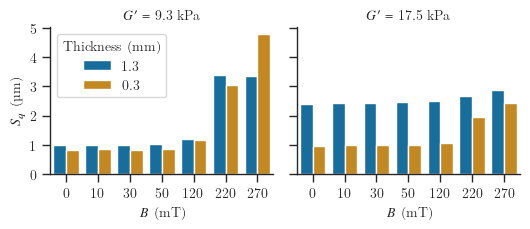

In [6]:
df = pd.read_csv(source_dir / "compare_magn"/ "roughness_final.csv")
sns.color_palette("colorblind")
# df = df.replace({"quer":"$\\rightarrow$120","120":"$\\uparrow$120","220":"$\\uparrow$220","270":"$\\uparrow$270","380":"$\\uparrow$380"})
df = df[df["magn"] != "quer"]
df["magn"] = df["magn"].astype(int)
df["th"] = df["th"].astype(str)
df["G_th"] = df["G"].astype(str) + "_" + df["th"]
df["pertesla"] = df["Sq"]/df["magn"]

print(df[df["magn"] == 220][["pertesla","G","th"]])
grps = df.copy().groupby("G_th")
def norm_sq(x):
    return x /x.min()
df["Sq_n"] = grps["Sq"].transform(norm_sq)

# sns.set_theme(palette="colorblind", style="ticks")
grid = sns.catplot(data=df, x="magn", y="Sq", col="G",  hue="th", kind="bar", hue_order={"0.3","1.3"}, height=3
                   , sharey=True, sharex=True, aspect=1, legend_out=False)
grid.legend.set_title("Thickness (mm)")

grid.set_titles(col_template="$G' =$ {col_name} kPa")
grid.set_xlabels("$B$ (mT)")
grid.set_ylabels("$S_q$ (µm)")
# plt.subplots_adjust(right=0.8)
grid.figure.set_figwidth(5.4)
grid.figure.set_figheight(2.4)
plt.tight_layout()

grid.figure.axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
grid.savefig(plot_out_dir / "figureA8_roughness.pdf")
df.rename(columns={"magn":"Magnetic Field (mT)", "Sq":"Sq (um)", "G":"Shear Modulus (kPa)", "th":"Thickness (mm)"}, inplace=True)
df.to_csv(plot_out_dir / "figureA8_roughness.csv", index=False)

### Effects of variables

In [ ]:
from matplotlib import pyplot as plt
from ridge_eval.ridge_models import style_exact

fig,axes = plt.subplots(1,4, figsize=(10,4), sharey=True, sharex=False)
subplot_labels = ["a)","b)","c)", "d)"]
x = np.linspace(0.0001, 0.0015, 250)
norm_x = x / 0.001
for e in [2000, 5000, 10000, 20000, 50000]:
    axes[0].set_title("E")
    fit_y = style_exact(x, 0.072, 1e-3, 39e-3, e, 1e-3)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[0], label=f"{e} Pa")
    axes[0].set_xlabel("r/R")
    axes[0].set_ylabel("Height (µm)")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes)

for ups in np.linspace(0.001,0.1,5):
    axes[1].set_title("Upsilon")
    fit_y = style_exact(x, 0.072, 1e-3, ups, 5000, 0.051e-3)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[1], label=f"{ups*1000:.0f} mN/m")
    axes[1].set_xlabel("r/R")
    axes[1].set_ylabel("Height (µm)")
    axes[1].set_xlim(0.9,1.3)
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes)

for h in np.linspace(0.00005,0.0015,5):
    axes[2].set_title("thickness")
    fit_y = style_exact(x, 0.072, 1e-3, 39e-3, 9000, h)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[2], label=f"{h*1000:.1f} mm")
    axes[2].set_xlabel("r/R")
    axes[2].set_ylabel("Height (µm)")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes)

for R in np.linspace(4e-4,3e-3,5):
    axes[3].set_title("radius")
    x = np.linspace(0.001*R, 2*R, 250)
    fit_y = style_exact(x, 0.072, R, 39e-3, 9000, 1e-3)*1e6
    print(fit_y.max())
    sns.lineplot(x=x/R, y=fit_y, ax=axes[3], label=f"{R*1000:.1f} mm")
    axes[3].set_xlabel("r/R")
    axes[3].set_ylabel("Height (µm)")
axes[3].text(0.05, 0.9, subplot_labels[3], transform=axes[3].transAxes)

plt.tight_layout()
plt.savefig(plot_out_dir / "variable_effects.pdf", bbox_inches="tight")